надо поставить detectron2, numpy, pandas, PIL, ast

In [37]:
import numpy as np
import pandas as pd
import cv2
import os
import json
from PIL import Image
import tqdm
import ast

In [8]:
folders = os.listdir('.')[1:-1]

In [99]:
folders[0].split()

['1)', 'Д=1342м,', 'Тангаж=0град,', 'Крен=0град']

In [12]:
datas = []
for i in folders:
    datas.append(pd.read_csv(os.path.join(i,'data.csv')))

In [15]:
data = pd.concat(datas).reset_index().drop(columns='index')

In [18]:
label = {'front':0, 'back':1,'rwing':2, 'lwing':3}

In [29]:
data.loc[0]

filename                                                              №1.jpg
file_size                                                             620196
file_attributes                                 {"width":3840,"height":2160}
region_count                                                               1
region_id                                                                  0
region_shape_attributes    {"name":"polygon","all_points_x":[954,2673,267...
region_attributes                                       {"category":"front"}
Name: 0, dtype: object

In [25]:
im = np.array(Image.open('1) Д=1342м, Тангаж=0град, Крен=0град'+'/№1.jpg').convert("RGB"))

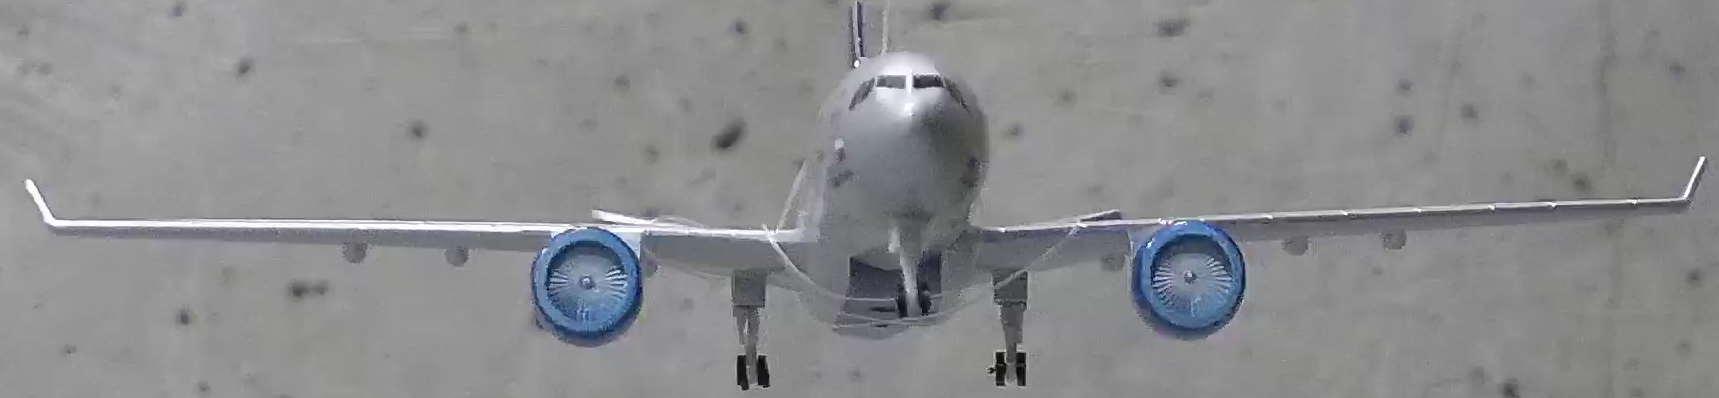

In [28]:
Image.fromarray(im[843:1241,954:2673])

In [170]:
idx = 0
dataset=[]
for folder in folders[:-1]:
    data = pd.read_csv(os.path.join(folder,'data.csv'))
    for row in data.iterrows():
#         im = Image.open(folder+'/'+row[1]['filename']).convert('RGB')
#         im.save('all_data/'+str(idx)+'.jpg')
        new = {'image_id':idx, 'file_name': str(idx)+'.jpg', 'annotations':[]}
        new['distance'] = int(folder.split()[1].split('=')[1][:-2])
        new['pitch'] = float(folder.split()[2].split('=')[1].replace(',','.')[:-5])
        new['roll'] = float(folder.split()[3].split('=')[1].replace(',','.')[:-4])        
        ann={}
        box = ast.literal_eval(row[1]['region_shape_attributes'])
        x1 = min(box["all_points_x"])
        x2 = max(box["all_points_x"])
        y1 = min(box["all_points_y"])
        y2 = max(box["all_points_y"])
        # convert x,y,w,h to x1,y1,x2,y2
        hw = ast.literal_eval(row[1]['file_attributes'])
        H, W = hw['height'], hw['width'] 
        new["width"] = W
        new["height"] = H
        width = max(0, x2 - x1)
        height = max(0, y2 - y1)
        ann['bbox'] = [x1, y1, width, height]
        ann['bbox_mode']= 1
        ann['category_id'] = label[ast.literal_eval(row[1]['region_attributes'])["category"]]
        new['annotations'].append(ann)
        idx+=1
        dataset.append(new)

In [171]:
json_name =  'all_data/{}.json'.format('train_data')
with open(json_name, 'w',  encoding='utf-8') as f:
    json.dump(dataset, f)

In [172]:
dataset=[]
for folder in folders[-1:]:
    data = pd.read_csv(os.path.join(folder,'data.csv'))
    for row in data.iterrows():
#         im = Image.open(folder+'/'+row[1]['filename']).convert('RGB')
#         im.save('all_data/'+str(idx)+'.jpg')
        new = {'image_id':idx, 'file_name': str(idx)+'.jpg', 'annotations':[]}
        new['distance'] = int(folder.split()[1].split('=')[1][:-2])
        new['pitch'] = float(folder.split()[2].split('=')[1].replace(',','.')[:-5])
        new['roll'] = float(folder.split()[3].split('=')[1].replace(',','.')[:-4])      
        ann={}
        box = ast.literal_eval(row[1]['region_shape_attributes'])
        x1 = min(box["all_points_x"])
        x2 = max(box["all_points_x"])
        y1 = min(box["all_points_y"])
        y2 = max(box["all_points_y"])
        # convert x,y,w,h to x1,y1,x2,y2
        hw = ast.literal_eval(row[1]['file_attributes'])
        H, W = hw['height'], hw['width'] 
        new["width"] = W
        new["height"] = H
        width = max(0, x2 - x1)
        height = max(0, y2 - y1)
        ann['bbox'] = [x1, y1, width, height]
        ann['bbox_mode']= 1
        ann['category_id'] = label[ast.literal_eval(row[1]['region_attributes'])["category"]]
        new['annotations'].append(ann)
        idx+=1
        dataset.append(new)

In [173]:
json_name =  'all_data/{}.json'.format('val_data')
with open(json_name, 'w', encoding='utf-8') as f:
    json.dump(dataset, f)

### надо подгрузить нужные библиотеки

In [1]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from PIL import Image
import cv2
from detectron2.utils.visualizer import ColorMode

In [2]:
import json
import random
from detectron2.structures import BoxMode
def get_board_dicts(imgdir, split):
    json_file = imgdir+"/"+split+"_data.json" #Fetch the json file
    with open(json_file,'r', encoding='utf-8') as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS #Setting the required Box Mode
            j["category_id"] = int(j["category_id"])
    return dataset_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog

In [3]:
for d in ["train", 'val']:
    if 'airplane_'+d in DatasetCatalog.keys():
        DatasetCatalog.pop('airplane_'+d)
    DatasetCatalog.register(
        "airplane_" + d, lambda d=d: get_board_dicts("all_data", d))
    MetadataCatalog.get(
        "airplane_" + d).set(thing_classes=['front', 'back', 'rwing', 'lwing'])
board_metadata = MetadataCatalog.get("airplane_train")

In [3]:
dataset_dicts = get_board_dicts('all_data','train')
imgs = []
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    imgs.append(Image.fromarray((vis.get_image())))

NameError: name 'cv2' is not defined

### обучение модели, но надо подготовить данные, которые у меня локально есть, пишите в личку за разметкой @demontego  в телеграм

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("airplane_train",)
cfg.DATASETS.TEST = ("airplane_val",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0125 # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 1500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA=2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # No. of classes = [HINDI, ENGLISH, OTHER]
# cfg.TEST.EVAL_PERIOD = 100 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/20 16:47:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/20 16:47:39 d2.data.build]: Removed 0 images with no usable annotations. 180 images left.
[11/20 16:47:39 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   front    | 66           |    back    | 15           |   rwing    | 55           |
|   lwing    | 44           |            |              |            |              |
|   total    | 180          |            |              |            |              |
[11/20 16:47:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/20 16:47:39 d2.data.build]: Using training sampler TrainingSampler
[11/20 16:47:39 d2.data.common]: Serializing 180 elements to byte tensors and concatenating them all ...
[11/20

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

In [5]:
trainer.train()

[11/20 16:47:42 d2.engine.train_loop]: Starting training from iteration 0
[11/20 16:47:52 d2.utils.events]:  eta: 0:07:33  iter: 19  total_loss: 1.207  loss_cls: 1.085  loss_box_reg: 0.1187  loss_rpn_cls: 0.0007262  loss_rpn_loc: 0.004917  time: 0.3066  data_time: 0.1102  lr: 0.00024976  max_mem: 2642M
[11/20 16:47:58 d2.utils.events]:  eta: 0:07:32  iter: 39  total_loss: 0.3389  loss_cls: 0.1591  loss_box_reg: 0.1583  loss_rpn_cls: 0.00124  loss_rpn_loc: 0.004486  time: 0.3056  data_time: 0.0016  lr: 0.00049951  max_mem: 2642M
[11/20 16:48:04 d2.utils.events]:  eta: 0:07:23  iter: 59  total_loss: 0.2955  loss_cls: 0.1291  loss_box_reg: 0.1642  loss_rpn_cls: 0.0002857  loss_rpn_loc: 0.004526  time: 0.3039  data_time: 0.0015  lr: 0.00074926  max_mem: 2642M
[11/20 16:48:10 d2.utils.events]:  eta: 0:07:15  iter: 79  total_loss: 0.2909  loss_cls: 0.1174  loss_box_reg: 0.1692  loss_rpn_cls: 0.0001556  loss_rpn_loc: 0.003504  time: 0.3025  data_time: 0.0015  lr: 0.00099901  max_mem: 2642M
[1

[11/20 16:51:17 d2.utils.events]:  eta: 0:04:02  iter: 699  total_loss: 0.07174  loss_cls: 0.03821  loss_box_reg: 0.03135  loss_rpn_cls: 0.0001757  loss_rpn_loc: 0.004142  time: 0.3005  data_time: 0.0014  lr: 0.0087413  max_mem: 2642M
[11/20 16:51:22 d2.utils.events]:  eta: 0:03:56  iter: 719  total_loss: 0.07753  loss_cls: 0.0398  loss_box_reg: 0.02938  loss_rpn_cls: 0.0001915  loss_rpn_loc: 0.002888  time: 0.3002  data_time: 0.0014  lr: 0.008991  max_mem: 2642M
[11/20 16:51:28 d2.utils.events]:  eta: 0:03:50  iter: 739  total_loss: 0.06913  loss_cls: 0.03058  loss_box_reg: 0.03224  loss_rpn_cls: 0.0002123  loss_rpn_loc: 0.003214  time: 0.3000  data_time: 0.0015  lr: 0.0092408  max_mem: 2642M
[11/20 16:51:34 d2.utils.events]:  eta: 0:03:43  iter: 759  total_loss: 0.07223  loss_cls: 0.04055  loss_box_reg: 0.02679  loss_rpn_cls: 0.0001163  loss_rpn_loc: 0.0035  time: 0.2996  data_time: 0.0015  lr: 0.0094905  max_mem: 2642M
[11/20 16:51:40 d2.utils.events]:  eta: 0:03:37  iter: 779  tota

[11/20 16:54:37 d2.utils.events]:  eta: 0:00:36  iter: 1379  total_loss: 0.05074  loss_cls: 0.02518  loss_box_reg: 0.02344  loss_rpn_cls: 0.0002367  loss_rpn_loc: 0.003154  time: 0.2977  data_time: 0.0015  lr: 0.0125  max_mem: 2642M
[11/20 16:54:43 d2.utils.events]:  eta: 0:00:30  iter: 1399  total_loss: 0.0522  loss_cls: 0.02259  loss_box_reg: 0.02457  loss_rpn_cls: 0.0001813  loss_rpn_loc: 0.002588  time: 0.2977  data_time: 0.0014  lr: 0.0125  max_mem: 2642M
[11/20 16:54:49 d2.utils.events]:  eta: 0:00:24  iter: 1419  total_loss: 0.05469  loss_cls: 0.02467  loss_box_reg: 0.02759  loss_rpn_cls: 0.0001625  loss_rpn_loc: 0.002438  time: 0.2976  data_time: 0.0014  lr: 0.0125  max_mem: 2642M
[11/20 16:54:55 d2.utils.events]:  eta: 0:00:18  iter: 1439  total_loss: 0.05275  loss_cls: 0.02145  loss_box_reg: 0.0265  loss_rpn_cls: 0.0001204  loss_rpn_loc: 0.002587  time: 0.2977  data_time: 0.0014  lr: 0.0125  max_mem: 2642M
[11/20 16:55:01 d2.utils.events]:  eta: 0:00:12  iter: 1459  total_los

In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    
        if output_folder is None:
            os.makedirs("eval", exist_ok=True)
            output_folder = "eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("airplane_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "airplane_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/20 16:56:22 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/20 16:56:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/20 16:56:22 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/20 16:56:22 d2.data.common]: Serialized dataset takes 0.00 MiB
[11/20 16:56:22 d2.evaluation.evaluator]: Start inference on 10 batches
[11/20 16:56:26 d2.evaluation.evaluator]: Total inference time: 0:00:00.592030 (0.118406 s / iter per device, on 1 devices)
[11/20 16:56:26 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.070589 s / iter per device, on 1 devices)
[11/20 16:56:26 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/20 16:56:26 d2.evaluation.coco_evaluation]: Saving results to ./

OrderedDict([('bbox',
              {'AP': 89.95874587458746,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 89.95874587458746,
               'AP-front': 95.54455445544554,
               'AP-back': 90.0,
               'AP-rwing': 84.29042904290428,
               'AP-lwing': 90.0})])

In [52]:
from detectron2.utils.visualizer import ColorMode
from detectron2.config import get_cfg
import os
#Use the final weights generated after successful training for inference  
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("airplane_train",)
cfg.DATASETS.TEST = ("airplane_val",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 6
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")   # Let training initialize from model zoo
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0125 # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 1500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA=2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # No. of classes = [HINDI, ENGLISH, OTHER]
# cfg.TEST.EVAL_PERIOD = 100 # No. of iterations after which the Validation Set is evaluated. 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
imgs=[]
dataset_dicts = get_board_dicts("all_data", 'val')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    visualizer = Visualizer(im[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=1,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    imgs.append([Image.fromarray((v.get_image())),Image.fromarray((vis.get_image()))])

In [11]:
board_metadata.thing_classes

['front', 'back', 'rwing', 'lwing']

In [280]:
ws,hs=[],[]
for d in dataset_dicts:
    if d['distance'] == 1342 and  d['annotations'][0]["category_id"]==3:
        w = d['annotations'][0]['bbox'][2]
        h = d['annotations'][0]['bbox'][3]
        ws.append(w)
        hs.append(h)
mean_w=np.mean(ws)
mean_h = np.mean(hs)
print(mean_w,mean_h)

1687.6666666666667 524.1666666666666


# Инференс модели, вверху надо инициализировать модель, чтобы работало

In [12]:
properties ={}
properties['front'] = {'KNOWN_DISTANCE': 2442,
'KNOWN_WIDTH' : 60 *(935.26/945),
'KNOWN_HEIGHT':  16.8 * (273.8/264)}
properties['front']['focalLength'] =  (945* properties['front']['KNOWN_DISTANCE']) / properties['front']['KNOWN_WIDTH']  

In [13]:
properties['lwing'] = {'KNOWN_DISTANCE': 1342,
'KNOWN_WIDTH' : 61 *(1629.28/1862),
'KNOWN_HEIGHT':  16.8 * (575.85/514)}
properties['lwing']['focalLength'] =  (1862* properties['lwing']['KNOWN_DISTANCE']) / properties['lwing']['KNOWN_WIDTH'] 
properties['rwing'] = {'KNOWN_DISTANCE': 1342,
'KNOWN_WIDTH' : 61 *(1687.66/1862),
'KNOWN_HEIGHT':  16.8 * (524.166/514)}
properties['rwing']['focalLength'] =  (1862* properties['rwing']['KNOWN_DISTANCE']) / properties['rwing']['KNOWN_WIDTH'] 

In [14]:
properties['back'] = {'KNOWN_DISTANCE': 2442,
'KNOWN_WIDTH' : 60 *(933.0/982),
'KNOWN_HEIGHT':  16.8 * (398.42/375)}
properties['back']['focalLength'] =  (982* properties['back']['KNOWN_DISTANCE']) / properties['back']['KNOWN_WIDTH'] 

In [15]:
def distance_to_camera(knownWidth, focalLength, perWidth):  
    # compute and return the distance from the maker to the camera
    return (knownWidth * focalLength) / perWidth  

In [16]:
import tqdm

In [33]:
outputs['instances'].image_size

(2160, 3840)

In [18]:
global errors

In [53]:
def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """
    
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break
#         if readFrames%25!=0:
#             readFrames += 1
#             cv2.putText(frame,"%.1fm" %  inches,(100,100), cv2.FONT_HERSHEY_SIMPLEX,
#                                                 2.0, (0, 255, 0), 3)
#             yield frame
#         else:
            # Get prediction results for this frame
        outputs = predictor(frame)
        pred = outputs["instances"].to("cpu")
        if pred.pred_classes.numpy().shape[0]==0:
            yield frame
        else:
            pred_cl = board_metadata.thing_classes[pred.pred_classes.numpy()[0]]
            boxes  =  pred.pred_boxes.tensor.detach().cpu().numpy()
            x_c = (boxes[0][2]+boxes[0][0])/2
            y_c = (boxes[0][3]+boxes[0][1])/2
            H,W = outputs['instances'].image_size
            azimut = (y_c-W/2)/(W/2)*5.6/2
            coner_place = (x_c-H/2)/(H/2)*3.74/2
            w = boxes[0][2]-boxes[0][0]
            # Make sure the frame is colored
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            
            # Draw a visualization of the predictions using the video visualizer
            v = Visualizer(frame,
                   metadata=board_metadata, 
                   scale=1,
                   instance_mode=ColorMode.IMAGE)
            v = v.draw_instance_predictions(pred)

            inches = distance_to_camera(properties[pred_cl]['KNOWN_WIDTH'], properties[pred_cl]['focalLength'] ,w)
            errors.append(inches)
            # Convert Matplotlib RGB format to OpenCV BGR format
            visualization = cv2.cvtColor(v.get_image(), cv2.COLOR_RGB2BGR)
            cv2.putText(visualization, "dist %.1f \
                        azimut %.2f \
                        corner place %.2f" % (inches,azimut, coner_place),(100,300), cv2.FONT_HERSHEY_SIMPLEX,
                                                2.0, (0, 255, 0), 3)
            yield visualization
        
        readFrames += 1  
        if readFrames > maxFrames:
            break


In [54]:
from detectron2.utils.video_visualizer import VideoVisualizer
import tqdm

In [56]:
video = cv2.VideoCapture("1) Д=2442м, Тангаж=0град, Крен=0град.mp4")
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(num_frames, frames_per_second)
num_frames = 1000
video_writer =cv2.VideoWriter('new_out120.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)
# Enumerate the frames of the video
for visualization in tqdm.notebook.tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write test image
    cv2.imwrite('POSE detectron2.png', visualization)

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()

2924 25.03738353656399


  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
np.mean(abs((np.array(errors)-2442)))

137.30618474538556

In [24]:
import numpy as np